In [1]:
import numpy as np
from TimeTagger import *
import matplotlib.pyplot as plt
from IPython.display import clear_output
import serial
import time
import datetime

In [2]:
# Establish the serial connection
ser = serial.Serial('COM8', 9600)  # Replace 'COM3' with your Arduino's port
tagger = createTimeTagger()

print(ser.readline())
print(ser.readline())
print(ser.readline())

b'Demonstration of AccelStepper Library\r\n'
b"Send 'C' for printing the commands.\r\n"
b'Default speed: 400 steps/s, default acceleration: 800 steps/s^2.\r\n'


In [3]:
import math
angle = math.atan(2/9)
cos = math.cos(angle)

In [4]:
SPAD_CH = 1 # SPAD Channel
TRIG_CH = 3 # Trigger Channel

bin_width = 34e-12 # in seconds, check once
c = 3*1e10 #cm
nbins = 6e4  #with the knowledge that delay will be in ns, we can acquire 1us worth of temporal data, ie 1us/ 100ps = 1e4 bins. 
#1ns = 30cm spatially so even 1e3 bins should do

npulse = 10 #100 pulses at every position
trigfreq = 1e3 # trigger frequency, 10kHz (can't go higher as of now)

# resolution = 0.01 #cm
# step_size = resolution

delay = 0.08 #delay between two acquisitions in sec
stepper_speed = 2 #cm/sec

total_distance = 14.5 #cm
n_acq = int((total_distance/stepper_speed)/delay) 

#to move 2cm, stepper motor will need 2*6400 steps. at this speed, it will move for 2*64 = 128 seconds lmao
# works ig
xdirection = 0 # 0 for left, 1 for right
ydirection = 0 # 0 for up, 1 for down
#t_acq = npulse/trigfreq #historgram acquisition time
t_acq = 0.01

In [5]:
print(f'Depth resolution: {np.round(bin_width*c,2)} cm')
print(f'Horizontal resolution: {stepper_speed*delay} cm')

# print(f'SPAD_CH: {SPAD_CH}')
# print(f'TRIG_CH: {TRIG_CH}')
# print(f'bin_width: {bin_width*1e12} picoseconds')
# print(f'nbins: {nbins}')
# #print(f'npulse: {npulse}')
# #print(f'trigfreq: {trigfreq} Hz')
# print(f'stepper_speed: {stepper_speed} steps/second')
print(f'dist_in_cm: {total_distance} cm')
print(f'number of acq: {n_acq} steps')
print(f't_acq: {t_acq} seconds')

Depth resolution: 1.02 cm
Horizontal resolution: 0.16 cm
dist_in_cm: 14.5 cm
number of acq: 90 steps
t_acq: 0.01 seconds


In [6]:

#Directions are given from the perspective facing HOLMARC sign in FSLab
def send_command(command):
    ser.write(command.encode())

def right_step(dist,speed):
    send_command(f'R{dist} {speed}')
    print(ser.readline())

def left_step(dist,speed):
    send_command(f'E{dist} {speed}')
    print(ser.readline())

# def x_step(dist, speed):
#     dist*=6400
#     speed*=6400
#     if xdirection.lower() == "up":
#         left_step(dist,speed)
#     elif xdirection.lower() == "down":
#         right_step(dist,speed)
#     else:
#         exit()    

# def y_step(dist, speed):
#     dist*=6400
#     speed*=6400
#     if ydirection.lower() == "left":
#         left_step(dist,speed)
#     elif ydirection.lower() == "right":
#         right_step(dist,speed)
#     else:
#         exit()


def x_step(dist, speed):
    dist*=6400
    speed*=6400
    if xdirection == 0:
        left_step(dist,speed)
    elif xdirection == 1:
        right_step(dist,speed)
    else:
        exit()    

def y_step(dist, speed):
    dist*=6400
    speed*=6400
    if ydirection == 0:
        up_step(dist,speed)
    elif ydirection == 1:
        down_step(dist,speed)
    else:
        exit()

def home_set():
    send_command('X')
    print(ser.readline())


def down_step(dist,speed):
    send_command(f'D{dist} {speed}')
    print(ser.readline())


def up_step(dist,speed):
    send_command(f'U{dist} {speed}')
    print(ser.readline())


def home_step():
    send_command('H')  
    print(ser.readline())
    print(ser.readline())
    print(ser.readline())

def getlocation():
    send_command('L')
    t =  int(ser.readline().split()[-1]), int(ser.readline().split()[-1])
    print(t)
    return t

def hist(t, bin_width, nbins):
    
    global SPAD_CH, TRIG_CH, tagger
    # print('a0) ',time.time())
    bin_width*=1e12
    t*=1e12 #every time data converted to ps
    hist = Histogram(tagger, SPAD_CH, TRIG_CH, bin_width, nbins)
    hist.startFor(t) #60e12 #in ps
    # print('a) ',time.time())
    while hist.isRunning():
        continue
    # print('b) ',time.time())    
    arr = np.array(hist.getData())
#    tt.getOverflowsAndClear()   
    #clear_output(wait=True)     
    # print('c) ',time.time())    
#    plt.plot(range(len(arr)),arr)
#    plt.show()
    # print('d) ',time.time())    
    x =  arr.argmax()*bin_width
    # print('e) ',time.time())
    return x # returns x in picosecond

In [49]:
home_step()

b'Homing X and Y axes.\r\n'
b'X-axis is goimg to the home position.\r\n'
b'Y-axis is goimg to the home position.\r\n'


In [50]:
# 2d code

x_dist = 14.5 #cm
y_res = 0.1 #cm
y_dist = 3 #cm
n_acq = int((x_dist/stepper_speed)/delay) 
xdirection = 0

num_ysteps = int(y_dist / y_res)

home_set()


start_time = time.time()

time_delay_2d = []

for i in range(num_ysteps):
    x_step(x_dist,stepper_speed)
    time_array = np.arange(delay,delay*n_acq + delay,delay)

    time_delay_1d = []
    for i in range(n_acq):
        time_delay_1d.append(hist(t_acq,bin_width,nbins))
        if i%100==0:
            print(i)
        while time.time()<=start_time + time_array[i]:
            continue
    time_delay_2d.append(time_delay_1d)

    time.sleep(10)
    y_step(y_res,stepper_speed)
    xdirection = not(xdirection)
    time.sleep(2)


home_step()

b'Current positions are updated to 0.\r\n'
b'Positive direction for X-axis.\r\n'
0
b'Negative direction for Y-axis.\r\n'
b'Negative direction for X-axis.\r\n'
0
b'Negative direction for Y-axis.\r\n'
b'Positive direction for X-axis.\r\n'
0
b'Negative direction for Y-axis.\r\n'
b'Negative direction for X-axis.\r\n'
0
b'Negative direction for Y-axis.\r\n'
b'Positive direction for X-axis.\r\n'
0
b'Negative direction for Y-axis.\r\n'
b'Negative direction for X-axis.\r\n'
0
b'Negative direction for Y-axis.\r\n'
b'Positive direction for X-axis.\r\n'
0
b'Negative direction for Y-axis.\r\n'
b'Negative direction for X-axis.\r\n'
0
b'Negative direction for Y-axis.\r\n'
b'Positive direction for X-axis.\r\n'
0
b'Negative direction for Y-axis.\r\n'
b'Negative direction for X-axis.\r\n'
0
b'Negative direction for Y-axis.\r\n'
b'Positive direction for X-axis.\r\n'
0
b'Negative direction for Y-axis.\r\n'
b'Negative direction for X-axis.\r\n'
0
b'Negative direction for Y-axis.\r\n'
b'Positive direction 

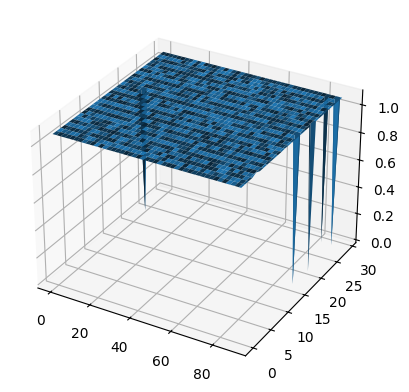

In [51]:

a = np.array(time_delay_2d)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

y = np.array(range(len(time_delay_2d)))
x = np.array(range(len(time_delay_2d[0])))
x, y = np.meshgrid(x, y)

ax.plot_surface(x, y, a)

plt.show()

In [54]:
np.matrix(time_delay_2d)

matrix([[1068722., 1068654., 1069232., ..., 1068858., 1068688., 1068688.],
        [1068620., 1068620., 1068926., ..., 1069028., 1068926., 1068756.],
        [1068722., 1068892., 1068654., ..., 1068280., 1068858., 1069028.],
        ...,
        [1068586., 1068586., 1068450., ..., 1068858., 1068246., 1068824.],
        [1068892., 1068926., 1068824., ..., 1069470.,       0., 1068926.],
        [1068892., 1068586., 1068348., ..., 1068790., 1068484., 1068586.]])

In [9]:
# home_set()

# time_array = np.arange(delay,delay*n_acq + delay,delay)
# time_delay = []

# start_time = time.time()
# # time.time() --> has a ~millisecond resolution
# y_step(total_distance,stepper_speed)
# for i in range(n_acq):
#     print('f) ',time.time())
#     time_delay.append(hist(t_acq,bin_width,nbins))
#     if i%100==0:
#         print(i)
#     print('f) ',time.time())
#     while time.time()<=start_time + time_array[i]:
#         continue
#     print('g) ',time.time())
# time_delay = np.array(time_delay)
# #plt.plot(time_delay*1e-12*c)
# #plt.show()
# home_step()


step_size2 = 100 #take 100 steps every turn for niter iterations #100/6400 ~ 
niter = nsteps/step_size2
#pseudo
for i in range(niter):
    #take a step right_step(step_size2, stepper_speed)
    # retrieve location
    # if location is what we expect
    # take and save histogram
    # repeat

In [56]:
np.savetxt(f'Z:/YRF/Experiments/Imaging/Jan_29/{str(datetime.datetime.now()).replace(" ","_").replace(":","_")}_{delay}sec_{np.round(bin_width*c,2)}dres.txt',time_delay_2d)